In [1]:
from scipy.io import loadmat
import numpy as np
from scipy.fft import fftshift, fftn, ifftn, fft, ifft, fftfreq
from skimage.measure import marching_cubes_lewiner
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

In [2]:
mat_dict = loadmat('Testdata.mat')
data = mat_dict['Undata']

In [68]:
L = 15 # Spatial domain
n = 64 # Spectral resolution / limits of ultrasound
x2 = np.linspace(-L, L, n + 1)
x = x2[:-1]
y = x
z = x
k = (2 * np.pi / (2 * L)) * np.concatenate([np.arange(0, n / 2), np.arange(- n / 2,0) ])
k = fftshift(k)
data = data.reshape(20, n, n, n)
[Kx, Ky, Kz] = np.meshgrid(k, k, k)


In [52]:
k

array([-6.70206433, -6.49262482, -6.28318531, -6.0737458 , -5.86430629,
       -5.65486678, -5.44542727, -5.23598776, -5.02654825, -4.81710874,
       -4.60766923, -4.39822972, -4.1887902 , -3.97935069, -3.76991118,
       -3.56047167, -3.35103216, -3.14159265, -2.93215314, -2.72271363,
       -2.51327412, -2.30383461, -2.0943951 , -1.88495559, -1.67551608,
       -1.46607657, -1.25663706, -1.04719755, -0.83775804, -0.62831853,
       -0.41887902, -0.20943951,  0.        ,  0.20943951,  0.41887902,
        0.62831853,  0.83775804,  1.04719755,  1.25663706,  1.46607657,
        1.67551608,  1.88495559,  2.0943951 ,  2.30383461,  2.51327412,
        2.72271363,  2.93215314,  3.14159265,  3.35103216,  3.56047167,
        3.76991118,  3.97935069,  4.1887902 ,  4.39822972,  4.60766923,
        4.81710874,  5.02654825,  5.23598776,  5.44542727,  5.65486678,
        5.86430629,  6.0737458 ,  6.28318531,  6.49262482])

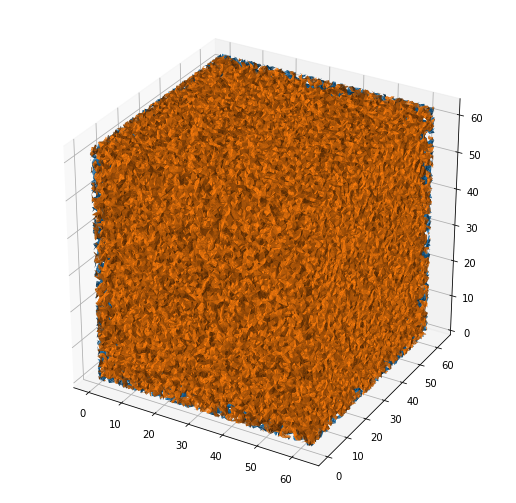

In [41]:
fig = plt.figure(figsize=(9,9))
ax = fig.add_subplot(111, projection='3d')

for i in range(2):
    verts, faces, _, _ = marching_cubes_lewiner(np.abs(data[i]), 0.4)
    ax.plot_trisurf(verts[:, 0], verts[:, 1], faces, verts[:, 2])
plt.show()


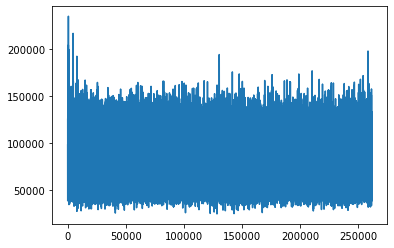

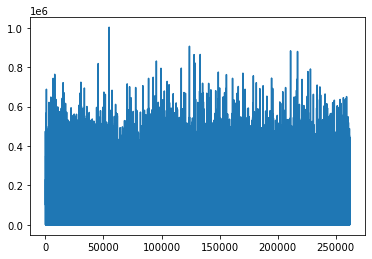

In [56]:
'''
Treat the data as 20 noisy 3d images => average over 20 3d spectra
'''

ave_spectrum_3d = np.zeros(shape=(n, n, n))
tau = 20
nbins = 128

for i in range(tau):
    f_hat = fftn(data[i])
    ave_spectrum_3d = ave_spectrum_3d + np.abs(f_hat)**2 # Magnitudes
    # plt.plot(np.abs(f_hat).ravel()**2)

ave_spectrum_3d = ave_spectrum_3d / tau
plt.plot(ave_spectrum_3d.ravel())
plt.show()

plt.plot(np.abs(f_hat).ravel()**2)
plt.show()

In [58]:
'''
Determine (spatial?) frequency signature of marble
'''
keep = 0.00001
sorted_coeffs = - np.sort(-ave_spectrum_3d, axis=None) # Descending order
thresh = sorted_coeffs[:int(keep * sorted_coeffs.size)].min()
idx = (ave_spectrum_3d > thresh).astype(bool)
mask = idx.astype(int)
Kx[idx] * (2 * L / (2 * np.pi)), Ky[idx] * (2 * L / (2 * np.pi)), Kz[idx] * (2 * L / (2 * np.pi))

(array([-23.]), array([-32.]), array([28.]))

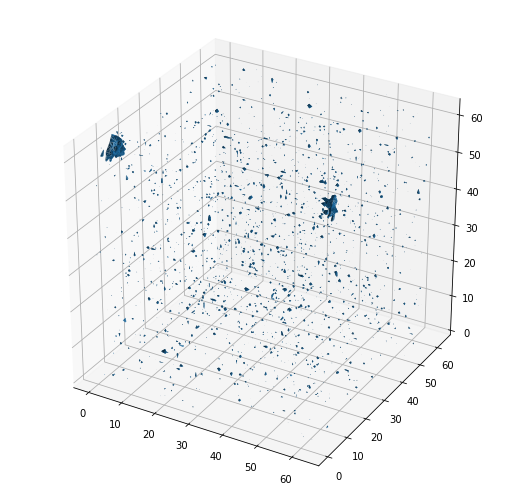

In [59]:
'''
Plot 3d average spectrum
'''
fig = plt.figure(figsize=(9,9))
ax = fig.add_subplot(111, projection='3d')

verts, faces, _, _ = marching_cubes_lewiner(ave_spectrum_3d)
ax.plot_trisurf(verts[:, 0], verts[:, 1], faces, verts[:, 2])
plt.show()

In [14]:
ave_spectrum_3d[idx].shape

(25,)

In [83]:
'''
Filter by the average spectrum
'''
keep = 0.00003
sorted_coeffs = - np.sort(-ave_spectrum_3d, axis=None) # Descending order
thresh = sorted_coeffs[:int(keep * sorted_coeffs.size)].min()
idx = (ave_spectrum_3d > thresh).astype(int)

filtered_data = []
for i in range(tau):
    f_hat = fftn(data[i])
    f_hat = f_hat * idx
    filtered_data.append(ifftn(f_hat))

filtered_data = np.stack(filtered_data, axis=0)

RuntimeError: No surface found at the given iso value.

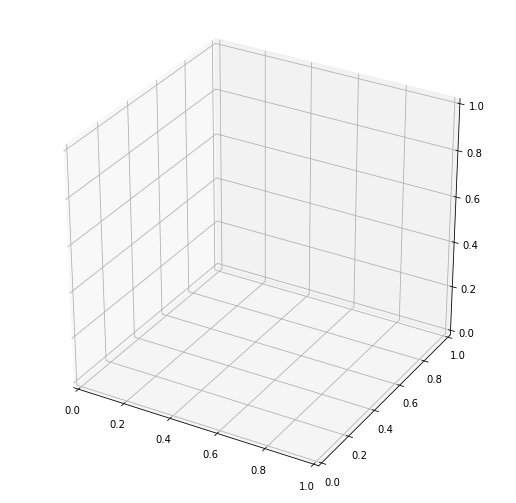

In [61]:


for i in range(3):
    fig = plt.figure(figsize=(9,9))
    ax = fig.add_subplot(111, projection='3d')
    verts, faces, _, _ = marching_cubes_lewiner(np.abs(filtered_data[i]))
    ax.plot_trisurf(verts[:, 0], verts[:, 1], faces, verts[:, 2])
    plt.show()


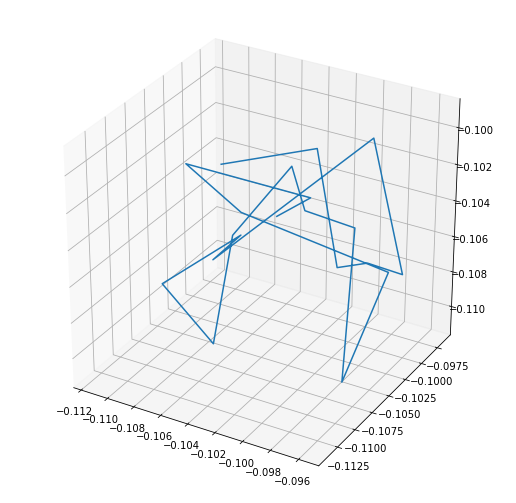

In [79]:
fig = plt.figure(figsize=(9,9))
ax = fig.add_subplot(111, projection='3d')
points = []
for i in range(tau):
    foo = np.abs(data[i])
    foo_x = foo.sum(axis=-1).sum(axis=-1)
    foo_y = foo.sum(axis=-1).sum(axis=0)
    foo_z = foo.sum(axis=0).sum(axis=0)

    ave_x = np.multiply(foo_x, k).sum() / foo_x.sum()
    ave_y = np.multiply(foo_y, k).sum() / foo_y.sum()
    ave_z = np.multiply(foo_z, k).sum() / foo_z.sum()
    points.append([ave_x, ave_y, ave_z])

points = np.vstack(points)
ax.plot(points[:,0], points[:,1], points[:,2])
plt.show()

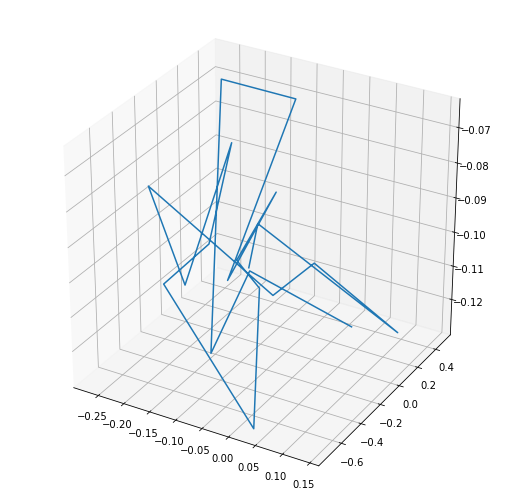

In [84]:
fig = plt.figure(figsize=(9,9))
ax = fig.add_subplot(111, projection='3d')
points = []
for i in range(tau):
    foo = np.abs(filtered_data[i])
    foo_x = foo.sum(axis=-1).sum(axis=-1)
    foo_y = foo.sum(axis=-1).sum(axis=0)
    foo_z = foo.sum(axis=0).sum(axis=0)

    ave_x = np.multiply(foo_x, k).sum() / foo_x.sum()
    ave_y = np.multiply(foo_y, k).sum() / foo_y.sum()
    ave_z = np.multiply(foo_z, k).sum() / foo_z.sum()
    points.append([ave_x, ave_y, ave_z])

points = np.vstack(points)
ax.plot(points[:,0], points[:,1], points[:,2])
plt.show()